This file contains the work to generate core users and feeding it to IDCF codebase for ML-100k dataset.
- greater than 30 interactions are taken into.
- Less than 30 interations are taken into test set
- some x% of coreusers are choosen as training set
- coreusers are calculated using CUR decomposition and R matrix is taken as coreuser.
- always the results are tested on test set.

In [1]:
from fileinput import filename
import pandas as pd
import numpy as np
from scipy import linalg
from scipy.sparse.linalg import svds
import random 
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import scipy.stats as ss
import pickle

- code to read and clean douban book review file.

In [23]:
ml1m_dir = 'data/bookreviews_cleaned.txt'
# ml1m_rating = pd.read_csv(ml1m_dir, delim_whitespace=True,index_col=0, engine='python')
ml1m_rating = pd.read_csv(ml1m_dir, delim_whitespace=True, usecols=range(3), header=None)
# df = ml1m_rating[["user_id", book_id", "rating", "time"]]
ml1m_rating.head()
ml1m_rating.to_csv('data/douban_bookreview.csv', index=False)


In [28]:
def ReadData(threshold=30):
    # uncomment this line for movielens dataset
    ml1m_dir = 'data/douban_bookreview.csv'
    ml1m_rating = pd.read_csv(ml1m_dir, sep=',', header=None, names=['uid', 'mid', 'rating'],  engine='python')
    # use the below 2 lines for pinterest dataset.
    # ml1m_dir = 'data/pin-interest-main.txt'
    # ml1m_rating = pd.read_csv(ml1m_dir, delim_whitespace=True, header=None, names=['uid', 'mid', 'rating', 'timestamp'],  engine='python')

    unique_uid = np.unique(np.array(ml1m_rating['uid'].tolist()))
    unique_mid = np.unique(np.array(ml1m_rating['mid'].tolist()))
    uid_dict = dict([(y,x) for x,y in enumerate(unique_uid)])
    mid_dict = dict([(y,x) for x,y in enumerate(unique_mid)])
    print('DICTIONARY PREPARED:')

    # init user item dictionary:
    
    uid_list = ml1m_rating['uid'].tolist()
    uid_list_len = len(uid_list)
    mid_list = ml1m_rating['mid'].tolist()
    mid_list_len = len(mid_list)
    rating_list = ml1m_rating['rating'].tolist()
    user_item_dict = {x:set() for x in range(len(unique_uid))}
    item_user_dict = {x:set() for x in range(len(unique_mid))}
    for i in range(uid_list_len):
        uid_list[i] = uid_dict[uid_list[i]]
        mid_list[i] = mid_dict[mid_list[i]]
        # rating_list[i] = 1 # comment this line if you want to activate explicit ratings
        user_item_dict[uid_list[i]].add(mid_list[i])
        item_user_dict[mid_list[i]].add(uid_list[i])
    tmp_df = pd.DataFrame({"uid":uid_list, "mid":mid_list, "ratings":rating_list})
    v = tmp_df.uid.value_counts()
    df = tmp_df[tmp_df.uid.isin(v.index[v.gt(threshold)])]
### code to store less than 30 interactions:
    df_less_30 = tmp_df[tmp_df.uid.isin(v.index[v.le(threshold)])]
    return df, df_less_30, len(np.unique(mid_list)), len(unique_uid)

In [30]:
THRESHOLD = 20 #split the users into test and train by threshold number of interactions. if greater than threshold then all interactions of that user goes into train set.
df_gt_30, df_le_30, unique_mids, unique_uids = ReadData(THRESHOLD)
print("GREATER THAN 30:\n", df_gt_30)
print("LESS THAN 30: \n", df_le_30)
print("GREATER THAN THRESHOLD: ", len(df_gt_30))
print("LESS THAN THRESHOLD: " ,len(df_le_30))
print("UNIQUE MIDS: ", unique_mids)
print("UNIQUE UIDS: ", unique_uids)

DICTIONARY PREPARED:
GREATER THAN 30:
          uid    mid  ratings
0        613  55945        3
1        613  81196        4
2        613  32933        4
3        613  62950        5
4        613  59289        4
...      ...    ...      ...
227246  1814   4305        5
227247  1814   5877        5
227248  1814    809        5
227249  1814   1022        4
227250  1814   1051        5

[220555 rows x 3 columns]
LESS THAN 30: 
          uid    mid  ratings
285     1707  53320        1
286     1707  60332        5
287     1707  56218        5
288     1707  56068        4
289     1707  51775        4
...      ...    ...      ...
226701  1960  64798        5
226702  1960  37438        4
226703  1960  36476        4
226704  1960  69785        4
226705  1960   5762        4

[6696 rows x 3 columns]
GREATER THAN THRESHOLD:  220555
LESS THAN THRESHOLD:  6696
UNIQUE MIDS:  95872
UNIQUE UIDS:  2212


In [31]:
support_test_df = df_gt_30.groupby("uid").tail(1)
# print(len(df_gt_30['uid']))
support_train_df = df_gt_30.drop(df_gt_30.groupby('uid').tail(1).index, inplace=False)
assert(len(df_gt_30)== len(support_test_df) + len(support_train_df))
# print(len(test_df))
# print(len(train_df))
query_test_df = df_le_30.groupby("uid").tail(1)
query_train_df = df_le_30.drop(df_le_30.groupby('uid').tail(1).index, inplace=False)
assert(len(df_le_30)== len(query_test_df) + len(query_train_df))
dic_support_train_df_uid_mapping = dict([(y,x) for x,y in enumerate(np.unique(support_train_df['uid']))])
dic_support_train_df_uid_rmapping = dict([(x,y) for x,y in enumerate(np.unique(support_train_df['uid']))])
### no need for mid mapping

uid_of_train_df = support_train_df['uid'].tolist()
for i in range(len(uid_of_train_df)):
    uid_of_train_df[i] = dic_support_train_df_uid_mapping[uid_of_train_df[i]]
# for index, row in train_df.iterrows():
#     train_df['uid'][index] = dic_train_df_uid_mapping[train_df['uid'][index]]
core_user_ko_input_train_df = pd.DataFrame({'uid':uid_of_train_df, 'mid':support_train_df['mid'], 'ratings':support_train_df['ratings']})
print("NUMBER OF USERS IN SUPPORT TEST:", len(np.unique(support_test_df['uid'])))
print("NUMBER OF USERS IN SUPPORT TRAIN", len(np.unique(support_train_df['uid'])))
print("NUMBER OF USERS IN QUERY TEST:", len(np.unique(query_test_df['uid'])))
print("NUMBER OF USERS IN QUERY TRAIN", len(np.unique(query_train_df['uid'])))

NUMBER OF USERS IN SUPPORT TEST: 1371
NUMBER OF USERS IN SUPPORT TRAIN 1371
NUMBER OF USERS IN QUERY TEST: 841
NUMBER OF USERS IN QUERY TRAIN 725


In [32]:
train_ui_dic = {}    
for user in range(unique_uids):
    train_ui_dic[user] = []
for index,row in support_train_df.iterrows():
        train_ui_dic[row['uid']].append(row['mid'])

- utility functions for CUR coreusers.

In [33]:
MAX_MID = 27277 + 1
def select_cols(mat, k, dup=False):
    # prob 1d array of probabilities of all columns
    prob = mat.T.dot(mat)
    prob = np.array(np.diagonal(prob))
    denom = np.abs(prob).sum(axis = 0)
    prob = prob/denom

    C = np.zeros((mat.shape[0], k))
    ind_cols = np.arange(0, prob.size)
    c_ind = []
    i = 0
    while(i < k):
        rand_sel = np.random.choice(ind_cols, 1, p=prob)
        if rand_sel in c_ind:
            continue
        c_ind.append(rand_sel[0])
        C[:, i] = mat[:, rand_sel[0]]
        i += 1
        # C[:, i] = C[:, i]/np.sqrt(k*prob[rand_sel[0]])

    return C, c_ind

def select_rows(mat, k, dup=False):

    prob = mat.dot(mat.T)
    prob = np.array(np.diagonal(prob))
    denom = np.abs(prob).sum(axis=0)
    prob = prob/denom
    print(prob)
    r = np.zeros((k, mat.shape[1]))
    ind_rows = np.arange(0, prob.size)
    r_ind = []
    i = 0
    while(i < k):
        # print(ind_rows)
        rand_sel = np.random.choice(ind_rows, 1, p=prob)
        if rand_sel in r_ind:
            continue
        r_ind.append(rand_sel[0])
        r[i, :] = mat[rand_sel[0], :]
        i += 1
        # r[i, :] = r[i, :]/np.sqrt(k*prob[rand_sel[0]])
    r_ind = np.array(r_ind)
    return r, r_ind

# def matIntersection(mat, c_ind, r_ind):
    
#     W = np.zeros((len(r_ind), len(c_ind)))
#     for i in range(len(r_ind)):
#         W[i] = mat[r_ind[i], c_ind]
    
#     return W

# def pseudoInverse(W):
#     # U = WP (W+)

#     # W = X.Z.YT
#     X, Z, YT = np.linalg.svd(W)
    
#     # W+ = Y.Z+.XT
#     XT = X.T
#     Y = YT.T
#     # Z+ = reciprocal(Z)
#     ZP = np.reciprocal(Z)
#     ZP = sp.spdiags(ZP, 0, ZP.size, ZP.size)
#     ZP = ZP@ZP
    
#     # W+ = Y.Z+.XT
#     WP = Y@ZP
#     WP = WP@XT

#     return WP

In [34]:
def ExtractCoreUsers(dataframe, unique_user_len, unique_item_len):
    # print("# of rows in ml1m_ratings: ", len(dataframe))
    u_len = unique_user_len
    print("USER LEN:", u_len)
    # print(user_id)

    m_len = unique_item_len
    print("MOVIE LEN:", m_len)
    userItemMatrix = np.zeros(shape=(u_len, m_len))
    # print(userItemMatrix)

    for index, row in dataframe.iterrows():
        userItemMatrix[row['uid']][row['mid']] = row['ratings']
        # print(row['uid'], row['mid'])
    print("USER ITEM MATRIX: \n", userItemMatrix)

    df = pd.DataFrame(userItemMatrix)
    cosineSimilarity = cosine_similarity(df)
    print("SHAPE OF COSINE MATIX:\n ", cosineSimilarity.shape)

    listToStoreTopFiftyOfEveryUser = []
    for i in range(0, cosineSimilarity.shape[0]):
        idx = np.argpartition(cosineSimilarity[i], -50)[-50:]
        listToStoreTopFiftyOfEveryUser.append(idx)
    # print("Top fifty list: \n", listToStoreTopFiftyOfEveryUser)
    # listToStoreTopFiftyOfEveryUser = np.array(listToStoreTopFiftyOfEveryUser)
    flatten = np.concatenate(listToStoreTopFiftyOfEveryUser)
    listToStoreTopFiftyOfEveryUser = flatten.ravel()

    # print("List of top 50", listToStoreTopFiftyOfEveryUser)
    df = pd.DataFrame(listToStoreTopFiftyOfEveryUser)
    allUserList = df.value_counts().index.tolist()
    # print("ALL USERS LIST", allUserList)
    allUserList = list(sum(allUserList,()))
    # print("ALL USERS LIST", allUserList)
    twentyPercentUserList = allUserList[:int(len(allUserList)*0.2)]
    # print("TWENTY PERCENT USER:", len(twentyPercentUserList))
    # print("TWENTY PERCENT USER:", (twentyPercentUserList))
    coreusers = dataframe.iloc[np.where(dataframe.uid.isin(twentyPercentUserList))]
    # coreusers.reset_index()
    # print("CORE USERS:\n", coreusers)
    return coreusers

In [35]:
def CUR_ExtractCoreUsers(dataframe, unique_user_len, unique_item_len):
    # print("# of rows in ml1m_ratings: ", len(dataframe))
    u_len = unique_user_len
    print("USER LEN:", u_len)
    # print(user_id)

    m_len = unique_item_len
    print("MOVIE LEN:", m_len)
    userItemMatrix = np.zeros(shape=(u_len, m_len))
    # print(userItemMatrix)

    for index, row in dataframe.iterrows():
        userItemMatrix[row['uid']][row['mid']] = row['ratings']
        # print(row['uid'], row['mid'])
    print("USER ITEM MATRIX: \n", userItemMatrix)

    mat = userItemMatrix
    print("MAT:", mat)
    print(mat.shape)
    C, c_ind = select_cols(mat, int(u_len * 0.10)) ## getting 20% core users
    r, r_ind= select_rows(mat, int(u_len * 0.10))
    print("r", r)
    print("r_ind len", len(r_ind))

    cur_coreusers = dataframe.iloc[np.where(dataframe.uid.isin(r_ind))]
    # coreusers.reset_index()
    # print("CORE USERS:\n", coreusers)
    return cur_coreusers

In [36]:
# core_users = CUR_ExtractCoreUsers(core_user_ko_input_train_df, len(np.unique(uid_of_train_df)), unique_mids)
core_users = ExtractCoreUsers(core_user_ko_input_train_df, len(np.unique(uid_of_train_df)), unique_mids)
support_user_list = np.unique(core_users['uid'])
print("CORE USERS:" ,core_users)
print("NUMBER OF CORE USERS:", len(support_user_list))

USER LEN: 1371
MOVIE LEN: 95872
USER ITEM MATRIX: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
SHAPE OF COSINE MATIX:
  (1371, 1371)
CORE USERS:         uid    mid  ratings
0       262  55945        3
1       262  81196        4
2       262  32933        4
3       262  62950        5
4       262  59289        4
...     ...    ...      ...
226836  359  32270        4
226837  359  85114        5
226838  359  44411        3
226839  359  83714        5
226840  359   6924        5

[46357 rows x 3 columns]
NUMBER OF CORE USERS: 274


In [33]:
print(len(support_user_list))
len(np.unique(uid_of_train_df))
# print()

523


5231

In [37]:
core_users_index_list = core_users.index.to_list()
# non_core_user_index = (train_df.index.difference(core_users.index))
# non_core_user_index = non_core_user_index.tolist()

core_users_df = support_train_df.loc[core_users_index_list]
# non_core_user_df = train_df.loc[non_core_user_index]
# print("NON CORE USERS:" ,non_core_user_df)
print("CORE USERS:" ,core_users)

CORE USERS:         uid    mid  ratings
0       262  55945        3
1       262  81196        4
2       262  32933        4
3       262  62950        5
4       262  59289        4
...     ...    ...      ...
226836  359  32270        4
226837  359  85114        5
226838  359  44411        3
226839  359  83714        5
226840  359   6924        5

[46357 rows x 3 columns]


In [38]:
# print("TEST DF CONTAINS TEST FOR CORE AND NON CORE ENTITIES:\n" ,test_df)
# print(core_users['uid'])
unique_uids_in_support_trian = np.unique(np.array(core_users_df['uid']))
unique_uids_in_query_trian = np.unique(query_train_df['uid'])
print(len(unique_uids_in_support_trian))
support_test_df = support_test_df.loc[support_test_df['uid'].isin(unique_uids_in_support_trian)]
print("SUPPORT TEST DF:" ,support_test_df)
query_test_df = query_test_df
print("QUERY TEST DF:\n", query_test_df)

274
SUPPORT TEST DF:          uid    mid  ratings
284      613   6169        4
377     2024  83209        1
8073    1920  72451        3
9197     306   2331        5
9499    1447   1785        5
...      ...    ...      ...
225378  1965  31437        5
225529  1701   9819        2
226241  1740  72519        5
226689  1348   6066        5
226841   837  43146        1

[274 rows x 3 columns]
QUERY TEST DF:
          uid    mid  ratings
295     1707  87421        5
299     1620  18452        4
302     1889  74757        4
307      447  75026        4
346       70  69124        5
...      ...    ...      ...
225124   782  24626        5
225541   658  74333        5
226250  1958  29817        3
226261  1170  69547        4
226705  1960   5762        4

[841 rows x 3 columns]


In [39]:
support_train = []
for index,row in core_users_df.iterrows():
    support_train.append([row['uid'], row['mid'], row['ratings']])
query_train = []
for index, row in query_train_df.iterrows():
    query_train.append([row['uid'], row['mid'], row['ratings']])
support_test = []
for index, row in support_test_df.iterrows():
    support_test.append([row['uid'], row['mid'], row['ratings']])
query_test = []
for index, row in query_test_df.iterrows():
    query_test.append([row['uid'], row['mid'], row['ratings']])
user_his_dic = {}
for u in train_ui_dic.keys():
    user_his_dic[u] = train_ui_dic[u]
user_supp_list = np.unique(core_users_df['uid']).tolist()

In [40]:
import pickle
with open("douban_cos_10_support_as_core.pkl", "wb") as f:
    pickle.dump(support_train, f)
    pickle.dump(query_train, f)
    pickle.dump(support_test, f)
    pickle.dump(query_test, f)
    pickle.dump(user_supp_list, f)
    pickle.dump(user_his_dic, f)

- 10% douban cos coreusers into IDCF

In [43]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 46357/5855
test set size: support/query 274/841
Epoch 0 Step 44: Train 12.2825 Reg: 0.6802
Test: 7.6953 MAE: 2.6438 RMSE: 2.7740
Val: 5.5627 MAE: 2.1928 RMSE: 2.3585
Epoch 1 Step 88: Train 1.7782 Reg: 0.5602
Test: 0.8560 MAE: 0.7845 RMSE: 0.9252
Val: 0.8442 MAE: 0.6933 RMSE: 0.9188
Epoch 2 Step 132: Train 0.7528 Reg: 0.4985
Test: 0.8982 MAE: 0.8125 RMSE: 0.9477
Val: 0.7947 MAE: 0.6991 RMSE: 0.8915
Epoch 3 Step 176: Train 0.6989 Reg: 0.4343
Test: 0.8767 MAE: 0.7969 RMSE: 0.9363
Val: 0.7618 MAE: 0.6828 RMSE: 0.8728
Epoch 4 Step 220: Train 0.6519 Reg: 0.4576
Test: 0.8768 MAE: 0.7856 RMSE: 0.9364
Val: 0.7437 MAE: 0.6768 RMSE: 0.8624
Epoch 5 Step 264: Train 0.6098 Reg: 0.5074
Test: 0.8629 MAE: 0.7741 RMSE: 0.9289
Val: 0.7340 MAE: 0.6758 RMSE: 0.8567
Epoch 6 Step 308: Train 0.5686 Reg: 0.5686
Test: 0.8493 MAE: 0.7583 RMSE: 0.9215
Val: 0.7329 MAE: 0.6770 RMSE: 0.8561
Epoch 7 St

- 20% douban cos coueusers to IDCF

In [44]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 46357/5855
test set size: support/query 274/841
Epoch 0 Step 44: Train 11.9656 Reg: 0.6761
Test: 7.2786 MAE: 2.5661 RMSE: 2.6979
Val: 5.2677 MAE: 2.1348 RMSE: 2.2952
Epoch 1 Step 88: Train 1.6395 Reg: 0.5614
Test: 0.8084 MAE: 0.7567 RMSE: 0.8991
Val: 0.7807 MAE: 0.6783 RMSE: 0.8836
Epoch 2 Step 132: Train 0.7402 Reg: 0.5193
Test: 0.8985 MAE: 0.8114 RMSE: 0.9479
Val: 0.7172 MAE: 0.6794 RMSE: 0.8468
Epoch 3 Step 176: Train 0.6737 Reg: 0.4771
Test: 0.8651 MAE: 0.7852 RMSE: 0.9301
Val: 0.6839 MAE: 0.6604 RMSE: 0.8270
Epoch 4 Step 220: Train 0.6227 Reg: 0.5141
Test: 0.8630 MAE: 0.7752 RMSE: 0.9290
Val: 0.6689 MAE: 0.6551 RMSE: 0.8179
Epoch 5 Step 264: Train 0.5761 Reg: 0.5762
Test: 0.8428 MAE: 0.7567 RMSE: 0.9180
Val: 0.6663 MAE: 0.6542 RMSE: 0.8163
Epoch 6 Step 308: Train 0.5321 Reg: 0.6419
Test: 0.8316 MAE: 0.7484 RMSE: 0.9119
Val: 0.6705 MAE: 0.6545 RMSE: 0.8188
Epoch 7 St

- 40% douban cos core user as input to IDCF

In [45]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 92063/5855
test set size: support/query 548/841
Epoch 0 Step 86: Train 7.2229 Reg: 0.6657
Test: 0.9189 MAE: 0.8026 RMSE: 0.9586
Val: 0.8435 MAE: 0.6953 RMSE: 0.9184
Epoch 1 Step 172: Train 0.7773 Reg: 0.5546
Test: 0.9195 MAE: 0.8105 RMSE: 0.9589
Val: 0.7594 MAE: 0.6794 RMSE: 0.8715
Epoch 2 Step 258: Train 0.7084 Reg: 0.5705
Test: 0.8655 MAE: 0.7754 RMSE: 0.9303
Val: 0.7328 MAE: 0.6761 RMSE: 0.8560
Epoch 3 Step 344: Train 0.6666 Reg: 0.6927
Test: 0.8387 MAE: 0.7570 RMSE: 0.9158
Val: 0.7202 MAE: 0.6716 RMSE: 0.8487
Epoch 4 Step 430: Train 0.6312 Reg: 0.8148
Test: 0.8015 MAE: 0.7391 RMSE: 0.8953
Val: 0.7112 MAE: 0.6662 RMSE: 0.8433
Epoch 5 Step 516: Train 0.5963 Reg: 0.9169
Test: 0.8054 MAE: 0.7354 RMSE: 0.8974
Val: 0.7061 MAE: 0.6628 RMSE: 0.8403
Epoch 6 Step 602: Train 0.5600 Reg: 1.0043
Test: 0.8000 MAE: 0.7218 RMSE: 0.8944
Val: 0.7191 MAE: 0.6656 RMSE: 0.8480
Epoch 7 St

- 60% souban cos coreusers input to IDCF

In [46]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 131477/5855
test set size: support/query 822/841
Epoch 0 Step 122: Train 5.3803 Reg: 0.7330
Test: 1.0197 MAE: 0.8565 RMSE: 1.0098
Val: 0.7801 MAE: 0.6891 RMSE: 0.8832
Epoch 1 Step 244: Train 0.7439 Reg: 0.6692
Test: 0.9197 MAE: 0.7987 RMSE: 0.9590
Val: 0.7185 MAE: 0.6712 RMSE: 0.8476
Epoch 2 Step 366: Train 0.6923 Reg: 0.8223
Test: 0.8809 MAE: 0.7747 RMSE: 0.9385
Val: 0.7075 MAE: 0.6675 RMSE: 0.8411
Epoch 3 Step 488: Train 0.6609 Reg: 0.9764
Test: 0.8486 MAE: 0.7561 RMSE: 0.9212
Val: 0.7013 MAE: 0.6628 RMSE: 0.8374
Epoch 4 Step 610: Train 0.6335 Reg: 1.0855
Test: 0.8615 MAE: 0.7606 RMSE: 0.9282
Val: 0.6973 MAE: 0.6608 RMSE: 0.8350
Epoch 5 Step 732: Train 0.6081 Reg: 1.1619
Test: 0.8572 MAE: 0.7569 RMSE: 0.9258
Val: 0.6982 MAE: 0.6614 RMSE: 0.8356
Epoch 6 Step 854: Train 0.5824 Reg: 1.2139
Test: 0.8683 MAE: 0.7572 RMSE: 0.9318
Val: 0.7069 MAE: 0.6640 RMSE: 0.8408
Epoch 7 

- 80% douban cos into IDCF

In [24]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 84997/4938
test set size: support/query 584/213
Epoch 0 Step 79: Train 6.6028 Reg: 0.4592
Test: 1.1456 MAE: 0.8695 RMSE: 1.0703
Val: 1.1703 MAE: 0.8688 RMSE: 1.0818
Epoch 1 Step 158: Train 1.0108 Reg: 0.4572
Test: 0.9544 MAE: 0.7821 RMSE: 0.9769
Val: 0.9422 MAE: 0.7755 RMSE: 0.9707
Epoch 2 Step 237: Train 0.8862 Reg: 0.4287
Test: 0.9027 MAE: 0.7476 RMSE: 0.9501
Val: 0.8970 MAE: 0.7449 RMSE: 0.9471
Epoch 3 Step 316: Train 0.8556 Reg: 0.4094
Test: 0.8874 MAE: 0.7436 RMSE: 0.9420
Val: 0.8798 MAE: 0.7384 RMSE: 0.9380
Epoch 4 Step 395: Train 0.8451 Reg: 0.3925
Test: 0.8758 MAE: 0.7390 RMSE: 0.9359
Val: 0.8752 MAE: 0.7361 RMSE: 0.9355
Epoch 5 Step 474: Train 0.8399 Reg: 0.3775
Test: 0.8745 MAE: 0.7379 RMSE: 0.9352
Val: 0.8731 MAE: 0.7347 RMSE: 0.9344
Epoch 6 Step 553: Train 0.8369 Reg: 0.3643
Test: 0.8760 MAE: 0.7383 RMSE: 0.9360
Val: 0.8677 MAE: 0.7334 RMSE: 0.9315
Epoch 7 St

- 100% cur to IDCF

In [25]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 94119/4938
test set size: support/query 730/213
Epoch 0 Step 88: Train 6.3013 Reg: 0.4731
Test: 1.1631 MAE: 0.8794 RMSE: 1.0785
Val: 1.1481 MAE: 0.8679 RMSE: 1.0715
Epoch 1 Step 176: Train 0.9799 Reg: 0.4807
Test: 0.9898 MAE: 0.7880 RMSE: 0.9949
Val: 0.9420 MAE: 0.7761 RMSE: 0.9706
Epoch 2 Step 264: Train 0.8817 Reg: 0.4511
Test: 0.9535 MAE: 0.7665 RMSE: 0.9765
Val: 0.9005 MAE: 0.7492 RMSE: 0.9489
Epoch 3 Step 352: Train 0.8594 Reg: 0.4284
Test: 0.9378 MAE: 0.7609 RMSE: 0.9684
Val: 0.8895 MAE: 0.7459 RMSE: 0.9431
Epoch 4 Step 440: Train 0.8520 Reg: 0.4085
Test: 0.9343 MAE: 0.7601 RMSE: 0.9666
Val: 0.8844 MAE: 0.7432 RMSE: 0.9404
Epoch 5 Step 528: Train 0.8474 Reg: 0.3909
Test: 0.9287 MAE: 0.7562 RMSE: 0.9637
Val: 0.8821 MAE: 0.7417 RMSE: 0.9392
Epoch 6 Step 616: Train 0.8449 Reg: 0.3749
Test: 0.9285 MAE: 0.7568 RMSE: 0.9636
Val: 0.8819 MAE: 0.7411 RMSE: 0.9391
Epoch 7 St

- 10% cos input to IDCF

In [27]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 21136/4938
test set size: support/query 73/213
Epoch 0 Step 20: Train 12.6638 Reg: 0.4718
Test: 12.3028 MAE: 3.2904 RMSE: 3.5075
Val: 11.9895 MAE: 3.2932 RMSE: 3.4626
Epoch 1 Step 40: Train 9.5591 Reg: 0.3460
Test: 7.2368 MAE: 2.4206 RMSE: 2.6901
Val: 6.9091 MAE: 2.4159 RMSE: 2.6285
Epoch 2 Step 60: Train 3.7124 Reg: 0.2992
Test: 1.9068 MAE: 1.1742 RMSE: 1.3809
Val: 1.5862 MAE: 1.0526 RMSE: 1.2594
Epoch 3 Step 80: Train 1.1169 Reg: 0.2929
Test: 1.3503 MAE: 1.0018 RMSE: 1.1620
Val: 1.0567 MAE: 0.8650 RMSE: 1.0279
Epoch 4 Step 100: Train 0.9742 Reg: 0.2849
Test: 1.2662 MAE: 0.9685 RMSE: 1.1253
Val: 1.0115 MAE: 0.8424 RMSE: 1.0057
Epoch 5 Step 120: Train 0.8989 Reg: 0.2748
Test: 1.1744 MAE: 0.9315 RMSE: 1.0837
Val: 0.9631 MAE: 0.8255 RMSE: 0.9814
Epoch 6 Step 140: Train 0.8318 Reg: 0.2708
Test: 1.0948 MAE: 0.8897 RMSE: 1.0463
Val: 0.9213 MAE: 0.8032 RMSE: 0.9599
Epoch 7 Ste

- 20% cos as input to IDCF

In [28]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 35161/4938
test set size: support/query 146/213
Epoch 0 Step 33: Train 11.4273 Reg: 0.4319
Test: 8.3260 MAE: 2.6473 RMSE: 2.8855
Val: 8.1389 MAE: 2.6386 RMSE: 2.8529
Epoch 1 Step 66: Train 3.7433 Reg: 0.3295
Test: 1.2741 MAE: 0.9554 RMSE: 1.1287
Val: 1.1385 MAE: 0.8960 RMSE: 1.0670
Epoch 2 Step 99: Train 1.0736 Reg: 0.3249
Test: 1.1345 MAE: 0.9037 RMSE: 1.0651
Val: 1.0117 MAE: 0.8268 RMSE: 1.0058
Epoch 3 Step 132: Train 0.9606 Reg: 0.3070
Test: 1.0206 MAE: 0.8558 RMSE: 1.0103
Val: 0.9216 MAE: 0.7891 RMSE: 0.9600
Epoch 4 Step 165: Train 0.8713 Reg: 0.2983
Test: 0.9550 MAE: 0.8218 RMSE: 0.9772
Val: 0.8640 MAE: 0.7507 RMSE: 0.9295
Epoch 5 Step 198: Train 0.8172 Reg: 0.2949
Test: 0.9244 MAE: 0.7956 RMSE: 0.9614
Val: 0.8343 MAE: 0.7232 RMSE: 0.9134
Epoch 6 Step 231: Train 0.7864 Reg: 0.2913
Test: 0.9102 MAE: 0.7910 RMSE: 0.9540
Val: 0.8206 MAE: 0.7115 RMSE: 0.9059
Epoch 7 Ste

- 40% cos coreuser as input to IDCF

In [29]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 53579/4938
test set size: support/query 292/213
Epoch 0 Step 50: Train 9.7784 Reg: 0.4162
Test: 3.0406 MAE: 1.5091 RMSE: 1.7437
Val: 2.8062 MAE: 1.4576 RMSE: 1.6752
Epoch 1 Step 100: Train 1.2928 Reg: 0.3794
Test: 1.0240 MAE: 0.8422 RMSE: 1.0119
Val: 0.9759 MAE: 0.8137 RMSE: 0.9879
Epoch 2 Step 150: Train 0.9310 Reg: 0.3559
Test: 0.9223 MAE: 0.7884 RMSE: 0.9603
Val: 0.8766 MAE: 0.7547 RMSE: 0.9363
Epoch 3 Step 200: Train 0.8434 Reg: 0.3415
Test: 0.8839 MAE: 0.7614 RMSE: 0.9402
Val: 0.8446 MAE: 0.7253 RMSE: 0.9190
Epoch 4 Step 250: Train 0.8094 Reg: 0.3311
Test: 0.8675 MAE: 0.7527 RMSE: 0.9314
Val: 0.8324 MAE: 0.7165 RMSE: 0.9123
Epoch 5 Step 300: Train 0.7929 Reg: 0.3232
Test: 0.8536 MAE: 0.7499 RMSE: 0.9239
Val: 0.8271 MAE: 0.7146 RMSE: 0.9095
Epoch 6 Step 350: Train 0.7840 Reg: 0.3160
Test: 0.8489 MAE: 0.7490 RMSE: 0.9214
Val: 0.8254 MAE: 0.7140 RMSE: 0.9085
Epoch 7 St

- 60% cos coreuser as input to IDCF

In [30]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 69421/4938
test set size: support/query 438/213
Epoch 0 Step 65: Train 8.0660 Reg: 0.4288
Test: 1.1991 MAE: 0.9208 RMSE: 1.0950
Val: 1.1469 MAE: 0.8994 RMSE: 1.0709
Epoch 1 Step 130: Train 1.0294 Reg: 0.4167
Test: 1.0069 MAE: 0.8269 RMSE: 1.0035
Val: 0.9440 MAE: 0.7967 RMSE: 0.9716
Epoch 2 Step 195: Train 0.8774 Reg: 0.3873
Test: 0.9413 MAE: 0.7777 RMSE: 0.9702
Val: 0.8753 MAE: 0.7444 RMSE: 0.9356
Epoch 3 Step 260: Train 0.8325 Reg: 0.3716
Test: 0.9180 MAE: 0.7687 RMSE: 0.9581
Val: 0.8572 MAE: 0.7341 RMSE: 0.9258
Epoch 4 Step 325: Train 0.8156 Reg: 0.3606
Test: 0.9085 MAE: 0.7668 RMSE: 0.9531
Val: 0.8509 MAE: 0.7314 RMSE: 0.9224
Epoch 5 Step 390: Train 0.8080 Reg: 0.3490
Test: 0.9002 MAE: 0.7662 RMSE: 0.9488
Val: 0.8480 MAE: 0.7299 RMSE: 0.9209
Epoch 6 Step 455: Train 0.8033 Reg: 0.3393
Test: 0.8981 MAE: 0.7646 RMSE: 0.9477
Val: 0.8444 MAE: 0.7281 RMSE: 0.9189
Epoch 7 St

- 80% cos coreuser input to IDCF

In [32]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 82818/4938
test set size: support/query 584/213
Epoch 0 Step 77: Train 7.1442 Reg: 0.4514
Test: 1.1830 MAE: 0.8969 RMSE: 1.0877
Val: 1.1947 MAE: 0.8974 RMSE: 1.0930
Epoch 1 Step 154: Train 1.0317 Reg: 0.4582
Test: 0.9976 MAE: 0.8119 RMSE: 0.9988
Val: 0.9508 MAE: 0.7959 RMSE: 0.9751
Epoch 2 Step 231: Train 0.8932 Reg: 0.4244
Test: 0.9412 MAE: 0.7659 RMSE: 0.9702
Val: 0.8828 MAE: 0.7466 RMSE: 0.9396
Epoch 3 Step 308: Train 0.8560 Reg: 0.4039
Test: 0.9243 MAE: 0.7609 RMSE: 0.9614
Val: 0.8580 MAE: 0.7358 RMSE: 0.9263
Epoch 4 Step 385: Train 0.8422 Reg: 0.3869
Test: 0.9115 MAE: 0.7551 RMSE: 0.9547
Val: 0.8510 MAE: 0.7335 RMSE: 0.9225
Epoch 5 Step 462: Train 0.8360 Reg: 0.3731
Test: 0.9020 MAE: 0.7526 RMSE: 0.9497
Val: 0.8475 MAE: 0.7314 RMSE: 0.9206
Epoch 6 Step 539: Train 0.8322 Reg: 0.3608
Test: 0.9035 MAE: 0.7535 RMSE: 0.9505
Val: 0.8442 MAE: 0.7312 RMSE: 0.9188
Epoch 7 St

- 100% support user as cos core user to IDCF

In [33]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 94119/4938
test set size: support/query 730/213
Epoch 0 Step 88: Train 5.7745 Reg: 0.4774
Test: 1.1326 MAE: 0.8667 RMSE: 1.0642
Val: 1.1027 MAE: 0.8496 RMSE: 1.0501
Epoch 1 Step 176: Train 0.9613 Reg: 0.4771
Test: 0.9707 MAE: 0.7764 RMSE: 0.9852
Val: 0.9213 MAE: 0.7650 RMSE: 0.9599
Epoch 2 Step 264: Train 0.8752 Reg: 0.4516
Test: 0.9511 MAE: 0.7680 RMSE: 0.9753
Val: 0.8905 MAE: 0.7500 RMSE: 0.9436
Epoch 3 Step 352: Train 0.8573 Reg: 0.4304
Test: 0.9398 MAE: 0.7625 RMSE: 0.9695
Val: 0.8809 MAE: 0.7444 RMSE: 0.9385
Epoch 4 Step 440: Train 0.8505 Reg: 0.4110
Test: 0.9390 MAE: 0.7624 RMSE: 0.9690
Val: 0.8764 MAE: 0.7418 RMSE: 0.9362
Epoch 5 Step 528: Train 0.8464 Reg: 0.3934
Test: 0.9283 MAE: 0.7569 RMSE: 0.9635
Val: 0.8738 MAE: 0.7403 RMSE: 0.9348
Epoch 6 Step 616: Train 0.8440 Reg: 0.3785
Test: 0.9277 MAE: 0.7564 RMSE: 0.9632
Val: 0.8735 MAE: 0.7405 RMSE: 0.9346
Epoch 7 St

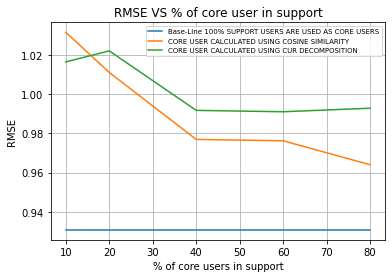

In [34]:
import matplotlib.pyplot as plt

x_axis = [10, 20, 40, 60, 80]
y_axis = [1.0315,1.011,0.9769, 0.9762, 0.9640]
x1_axis = [10, 20, 40, 60, 80]
y1_axis = [0.9308, 0.9308, 0.9308, 0.9308, 0.9308]
x2_axis = [10, 20, 40, 60, 80]
y2_axis = [1.0164, 1.022, 0.9917, 0.9910, 0.9528]

plt.plot(x1_axis, y1_axis, label="Base-Line 100% SUPPORT USERS ARE USED AS CORE USERS")
plt.plot(x_axis, y_axis, label="CORE USER CALCULATED USING COSINE SIMILARITY")
plt.plot(x2_axis, y2_axis, label="CORE USER CALCULATED USING CUR DECOMPOSITION")

plt.title('RMSE VS % of core user in support')
plt.xlabel('% of core users in support')
plt.ylabel('RMSE')
plt.grid()
plt.legend(fontsize=7)
plt.show()